In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA


In [2]:
# Load the CSV from the data folder
file_path = "../data/single_genre_artists.csv"
df = pd.read_csv(file_path)

# Quick look at the data
print("Shape:", df.shape)
df.head()


Shape: (95837, 23)


,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.184,4,...,0.993,0.000016,0.325,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.180,10,...,0.989,0.000000,0.128,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.206,0,...,0.995,0.000000,0.418,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.467,9,...,0.991,0.000000,0.219,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.298,9,...,0.991,0.000000,0.373,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22


In [3]:
# Basic info
df.info()

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Check for duplicates
print("\nDuplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95837 entries, 0 to 95836
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_songs            95837 non-null  object 
 1   name_song           95837 non-null  object 
 2   popularity_songs    95837 non-null  int64  
 3   duration_ms         95837 non-null  int64  
 4   explicit            95837 non-null  int64  
 5   id_artists          95837 non-null  object 
 6   release_date        95837 non-null  object 
 7   danceability        95837 non-null  float64
 8   energy              95837 non-null  float64
 9   key                 95837 non-null  int64  
 10  loudness            95837 non-null  float64
 11  mode                95837 non-null  int64  
 12  speechiness         95837 non-null  float64
 13  acousticness        95837 non-null  float64
 14  instrumentalness    95837 non-null  float64
 15  liveness            95837 non-null  float64
 16  vale

In [5]:
# Feature Selection 

features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]

# Filter only the available features
features = [f for f in features if f in df.columns]
print("Features selected:", features)

X = df[features].copy()

# Handle missing values by filling with median
X = X.fillna(X.median())

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Features selected: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


Running k=2...
Running k=3...
Running k=4...
Running k=5...
Running k=6...
Running k=7...
Running k=8...
Running k=9...
Running k=10...


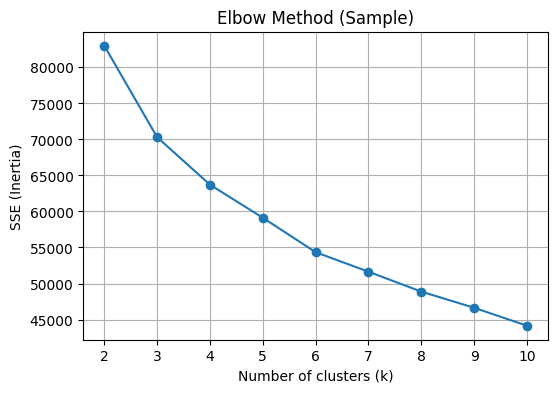

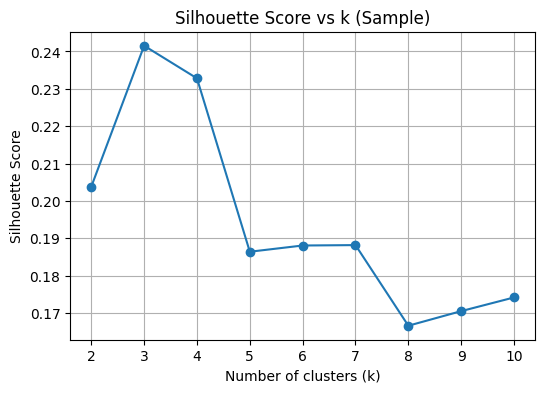

✅ Best k by Silhouette (sample): 3


In [7]:
# 🔥 FAST Elbow + Silhouette using a sample
from sklearn.utils import resample

# Take a random sample (e.g., 10k points) for faster elbow method
X_sample = resample(X_scaled, n_samples=10000, random_state=42)

inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    print(f"Running k={k}...")
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=42)  # n_init=5 for speed
    labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_sample, labels))

# Plot elbow
plt.figure(figsize=(6,4))
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method (Sample)')
plt.grid(True)
plt.show()

# Plot Silhouette
plt.figure(figsize=(6,4))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k (Sample)')
plt.grid(True)
plt.show()

best_k = K[np.argmax(silhouette_scores)]
print(f"✅ Best k by Silhouette (sample): {best_k}")


In [8]:
# Final K-Means Training & Evaluation

# Train final KMeans model on the full dataset using best_k
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df['cluster'] = cluster_labels

# Evaluate clustering performance
sil_score = silhouette_score(X_scaled, cluster_labels)
db_index = davies_bouldin_score(X_scaled, cluster_labels)

print(f"✅ Final KMeans Model (k={best_k})")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Preview some songs with their assigned clusters (if name columns exist)
cols_to_show = []
for c in ['name_song', 'name_artists']:
    if c in df.columns:
        cols_to_show.append(c)
cols_to_show.append('cluster')

df[cols_to_show].head(10)


✅ Final KMeans Model (k=3)
Silhouette Score: 0.2423
Davies-Bouldin Index: 1.5702


,name_song,name_artists,cluster
0,La Java,Mistinguett,1
1,En Douce,Mistinguett,1
2,J'en Ai Marre,Mistinguett,1
3,Ils n'ont pas ca,Mistinguett,1
4,La belote,Mistinguett,1
5,Oh mademoiselle,Mistinguett,1
6,Il m'a vue nue,Mistinguett,1
7,Mon Bus'ness,Mistinguett,1
8,Ça c'est Paris,Mistinguett,1
9,Le Fado,Mistinguett,1


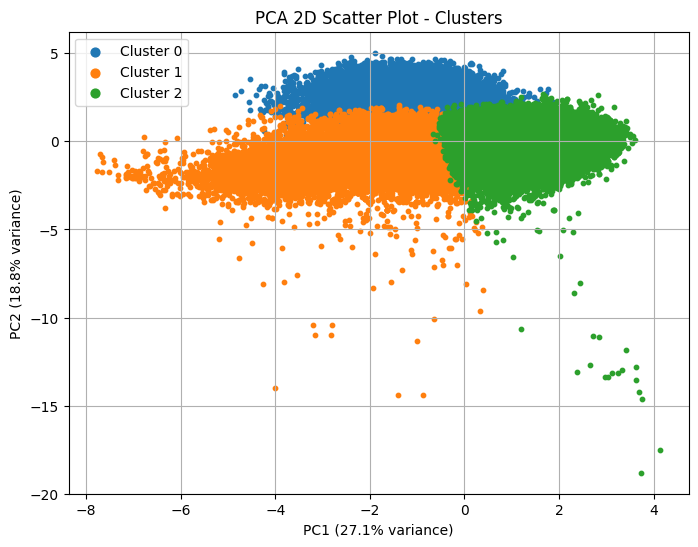

In [9]:
# PCA 2D Scatter Plot (Cluster Visualization)
# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

expl_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
for cluster_id in sorted(df['cluster'].unique()):
    mask = df['cluster'] == cluster_id
    plt.scatter(
        df.loc[mask, 'pca_1'],
        df.loc[mask, 'pca_2'],
        s=10,
        label=f'Cluster {cluster_id}'
    )

plt.xlabel(f'PC1 ({expl_var[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({expl_var[1]*100:.1f}% variance)')
plt.title('PCA 2D Scatter Plot - Clusters')
plt.legend(markerscale=2)
plt.grid(True)
plt.show()


Cluster Feature Profile (Means):


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
cluster,,,,,,,,,,
0,0.664271,0.466636,-13.363885,0.829978,0.585932,0.001385,0.435535,0.584036,100.389473,97520.590026
1,0.486381,0.311231,-13.205013,0.060140,0.749228,0.168547,0.182070,0.413254,111.939598,223457.063979
2,0.627345,0.693655,-7.606487,0.075064,0.258485,0.050703,0.199867,0.666416,124.911397,226592.052516


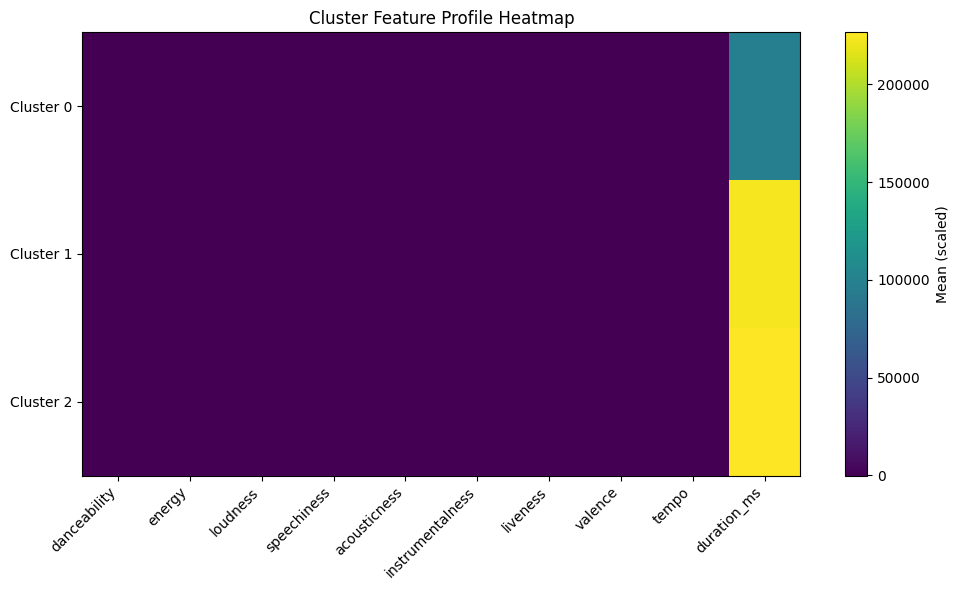

In [10]:
# Cluster Profile (Feature Means per Cluster)
# Compute cluster profiles (mean of each feature per cluster)
cluster_profile = df.groupby('cluster')[features].mean()

# Display profile table
print("Cluster Feature Profile (Means):")
display(cluster_profile)

# Heatmap for quick visual comparison
plt.figure(figsize=(10, 6))
plt.imshow(cluster_profile.values, aspect='auto')
plt.xticks(ticks=range(len(features)), labels=features, rotation=45, ha='right')
plt.yticks(ticks=range(cluster_profile.shape[0]), labels=[f"Cluster {i}" for i in cluster_profile.index])
plt.colorbar(label='Mean (scaled)')
plt.title('Cluster Feature Profile Heatmap')
plt.tight_layout()
plt.show()


In [11]:
# Export Final Clustered Dataset & Profiles

import os

# Create an 'output' folder to keep results clean
os.makedirs("../output", exist_ok=True)

# Paths
final_csv_path = "../output/amazon_music_clusters.csv"
profile_csv_path = "../output/cluster_profile.csv"
readme_path = "../output/README_Amazon_Music_Clustering.txt"

# Save final dataset with cluster labels and PCA columns
export_columns = ['cluster', 'pca_1', 'pca_2'] + features
for col in ['name_song', 'name_artists']:
    if col in df.columns:
        export_columns.insert(0, col)

df[export_columns].to_csv(final_csv_path, index=False)
print(f"✅ Final clustered dataset saved to: {final_csv_path}")

# Save cluster profile
cluster_profile.to_csv(profile_csv_path)
print(f"✅ Cluster profile saved to: {profile_csv_path}")

# Create a quick summary README
summary_text = f"""
Amazon Music Clustering - Project Summary
========================================

• Number of clusters: {best_k}
• Silhouette Score: {sil_score:.4f}
• Davies–Bouldin Index: {db_index:.4f}

Features used:
{", ".join(features)}

Files Exported:
- {final_csv_path}
- {profile_csv_path}

You can use these files for:
- Streamlit dashboards 🎛️
- Power BI / Tableau visualizations 📊
- Business presentations 📝
"""

with open(readme_path, "w", encoding="utf-8") as f:
    f.write(summary_text.strip())

print(f"✅ Project summary saved to: {readme_path}")


✅ Final clustered dataset saved to: ../output/amazon_music_clusters.csv
✅ Cluster profile saved to: ../output/cluster_profile.csv
✅ Project summary saved to: ../output/README_Amazon_Music_Clustering.txt
